# Interview Task – Data Engineering & Analytics


In [24]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### Import the datasets


In [25]:
df = pd.read_csv("aviation_data.csv")
print(df.head())

  FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
3       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 PM   
4       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   

             Airline  DelayMinutes  
0  American Airlines          15.0  
1              Delta           5.0  
2    United Airlines          25.0  
3  American Airlines          30.0  
4              Delta           NaN  


### Insert the datasets and fetch values from MySQL database


In [26]:
from sqlalchemy import create_engine, text
import os
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Retrieve database credentials from environment variables
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_PORT = os.getenv("DB_PORT")


connection_string = (
    f"mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

try:
    engine = create_engine(connection_string)
    # create table
    create_table_query = text(
        """
    CREATE TABLE IF NOT EXISTS aviation_data (
        id INT AUTO_INCREMENT PRIMARY KEY,
        FlightNumber TEXT,
        DepartureDate TEXT,
        DepartureTime TEXT,
        ArrivalDate TEXT,
        ArrivalTime TEXT,
        Airline TEXT,
        DelayMinutes FLOAT
    )"""
    )

    with engine.connect() as connection:
        connection.execute(create_table_query)

    df.to_sql("aviation_data", engine, if_exists="append", index=False)

    df_fetched = pd.read_sql("SELECT * FROM aviation_data", engine)

    print(df_fetched.head())

except Exception as e:
    print(f"Error: {e}")

finally:
    engine.dispose()

   id FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0   1       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1   2       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2   3       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
3   4       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 PM   
4   5       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   

             Airline  DelayMinutes  
0  American Airlines          15.0  
1              Delta           5.0  
2    United Airlines          25.0  
3  American Airlines          30.0  
4              Delta           NaN  


## DATA CLEANING

- a. Identify and handle any missing or inconsistent values in the dataset.


##### Data Cleaning : Missing Values

In [27]:
df = df_fetched

# Missing Values
def check_missing_values(df):
    print("Missing values before handling:")
    print(df.isnull().sum())

    df["DelayMinutes"] = df["DelayMinutes"].fillna(0)

    print("\nMissing values after handling:")
    print(df.isnull().sum())
    return df


df = check_missing_values(df)

Missing values before handling:
id                0
FlightNumber      0
DepartureDate     0
DepartureTime     0
ArrivalDate       0
ArrivalTime       0
Airline           0
DelayMinutes     14
dtype: int64

Missing values after handling:
id               0
FlightNumber     0
DepartureDate    0
DepartureTime    0
ArrivalDate      0
ArrivalTime      0
Airline          0
DelayMinutes     0
dtype: int64


##### Data Cleaning: Duplicate Values

In [28]:
# Check for duplicates
def check_duplicates(df):
    duplicate_count = df.duplicated(
        subset=[
            "FlightNumber",
            "DepartureDate",
            "DepartureTime",
            "ArrivalDate",
            "ArrivalTime",
            "Airline",
            "DelayMinutes",
        ]
    ).sum()
    print(f"\nNumber of duplicate entries: {duplicate_count}")

    # Remove duplicates
    df = df.drop_duplicates(
        subset=[
            "FlightNumber",
            "DepartureDate",
            "DepartureTime",
            "ArrivalDate",
            "ArrivalTime",
            "Airline",
            "DelayMinutes",
        ]
    )

    print(f"Number of entries after removing duplicates: {df.shape[0]}")
    return df



df = check_duplicates(df)


Number of duplicate entries: 72
Number of entries after removing duplicates: 12


##### Data Cleaning: Inconsistent Time Entries

In [29]:
def convert_to_24hr(time_str):
    return datetime.strptime(time_str, "%I:%M %p").strftime("%H:%M")


# Check for inconsistent time entries
def check_inconsistent_time_entries(df):
    inconsistent_time_entries = df[df["DepartureTime"] > df["ArrivalTime"]]
    print(f"Number of inconsistent time entries: {inconsistent_time_entries.shape[0]}")

    # Remove inconsistent time entries
    df = df[df["DepartureTime"] <= df["ArrivalTime"]]
    print(f"Number of entries after removing inconsistent time entries: {df.shape[0]}")

    # Convert DepartureTime and ArrivalTime to datetime.time
    df["DepartureTime_24"] = df["DepartureTime"].apply(convert_to_24hr)
    df["ArrivalTime_24"] = df["ArrivalTime"].apply(convert_to_24hr)

    # Combine DepartureDate and DepartureTime into a single datetime
    df["DepartureDateTime"] = pd.to_datetime(
        df["DepartureDate"] + " " + df["DepartureTime"], format="%m/%d/%Y %I:%M %p"
    )
    df["ArrivalDateTime"] = pd.to_datetime(
        df["ArrivalDate"] + " " + df["ArrivalTime"], format="%m/%d/%Y %I:%M %p"
    )
    print(df.head())
    return df


df = check_inconsistent_time_entries(df)

Number of inconsistent time entries: 1
Number of entries after removing inconsistent time entries: 11
   id FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0   1       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
1   2       DL5678    09/01/2023      01:15 PM  09/01/2023    03:30 PM   
2   3       UA9101    09/01/2023      05:00 PM  09/01/2023    07:15 PM   
3   4       AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 PM   
4   5       DL5678    09/02/2023      02:00 PM  09/02/2023    04:10 PM   

             Airline  DelayMinutes DepartureTime_24 ArrivalTime_24  \
0  American Airlines          15.0            08:30          10:45   
1              Delta           5.0            13:15          15:30   
2    United Airlines          25.0            17:00          19:15   
3  American Airlines          30.0            08:30          22:45   
4              Delta           0.0            14:00          16:10   

    DepartureDateTime     Arriva

- b. Ensure all column data types are appropriate (e.g., dates as date types, times as time types).


In [30]:
# Ensure all column data types are appropriate (e.g., dates as date types, times as time types).
df['FlightNumber'] = df['FlightNumber'].astype(str)
df["DepartureDate"] = pd.to_datetime(df["DepartureDate"])
df["ArrivalDate"] = pd.to_datetime(df["ArrivalDate"])
df["DepartureTime"] = pd.to_datetime(df["DepartureTime"])
df["ArrivalTime"] = pd.to_datetime(df["ArrivalTime"])
df["DelayMinutes"] = df["DelayMinutes"].astype(int)
df['Airline']=df['Airline'].astype(str)
print(df.dtypes)
print(df.head(5))

id                            int64
FlightNumber                 object
DepartureDate        datetime64[ns]
DepartureTime        datetime64[ns]
ArrivalDate          datetime64[ns]
ArrivalTime          datetime64[ns]
Airline                      object
DelayMinutes                  int64
DepartureTime_24             object
ArrivalTime_24               object
DepartureDateTime    datetime64[ns]
ArrivalDateTime      datetime64[ns]
dtype: object
   id FlightNumber DepartureDate       DepartureTime ArrivalDate  \
0   1       AA1234    2023-09-01 2024-09-29 08:30:00  2023-09-01   
1   2       DL5678    2023-09-01 2024-09-29 13:15:00  2023-09-01   
2   3       UA9101    2023-09-01 2024-09-29 17:00:00  2023-09-01   
3   4       AA1234    2023-09-01 2024-09-29 08:30:00  2023-09-01   
4   5       DL5678    2023-09-02 2024-09-29 14:00:00  2023-09-02   

          ArrivalTime            Airline  DelayMinutes DepartureTime_24  \
0 2024-09-29 10:45:00  American Airlines            15            08:3

- Correct any inconsistencies or errors in times (e.g., arrival time should be later than departure
time).

In [39]:
# Correct any inconsistencies or errors in times (e.g., arrival time should be later than departure time).
df = df[df["DepartureDateTime"] <= df["ArrivalDateTime"]]
print(df.head())

   id FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
0   1       AA1234    2023-09-01         08:30  2023-09-01       10:45   
1   2       DL5678    2023-09-01         13:15  2023-09-01       15:30   
2   3       UA9101    2023-09-01         17:00  2023-09-01       19:15   
3   4       AA1234    2023-09-01         08:30  2023-09-01       22:45   
4   5       DL5678    2023-09-02         14:00  2023-09-02       16:10   

             Airline  DelayMinutes   DepartureDateTime     ArrivalDateTime  \
0  American Airlines            15 2023-09-01 08:30:00 2023-09-01 10:45:00   
1              Delta             5 2023-09-01 13:15:00 2023-09-01 15:30:00   
2    United Airlines            25 2023-09-01 17:00:00 2023-09-01 19:15:00   
3  American Airlines            30 2023-09-01 08:30:00 2023-09-01 22:45:00   
4              Delta             0 2023-09-02 14:00:00 2023-09-02 16:10:00   

   FlightDuration  DepartureHour  
0           135.0              8  
1           135.

### Data Normalization
- a. Convert DepartureDate and ArrivalDate columns to a standard YYYY-MM-DD format.

In [32]:
# Convert DepartureDate and ArrivalDate to datetime and format as YYYY-MM-DD
df["DepartureDate"] = pd.to_datetime(
    df["DepartureDate"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")
df["ArrivalDate"] = pd.to_datetime(df["ArrivalDate"], format="%m/%d/%Y").dt.strftime(
    "%Y-%m-%d"
)

# Verify the changes
df[["DepartureDate", "ArrivalDate"]].head()

,DepartureDate,ArrivalDate
0,2023-09-01,2023-09-01
1,2023-09-01,2023-09-01
2,2023-09-01,2023-09-01
3,2023-09-01,2023-09-01
4,2023-09-02,2023-09-02


- b. Convert DepartureTime and ArrivalTime columns to a 24-hour time format (e.g., "08:30" for 8:30 AM).

In [33]:
# Optionally, replace the original time columns with 24-hour format
df["DepartureTime"] = df["DepartureTime_24"]
df["ArrivalTime"] = df["ArrivalTime_24"]

# Drop the temporary 24-hour columns
df = df.drop(["DepartureTime_24", "ArrivalTime_24"], axis=1)

# Verify the changes
df[["DepartureTime", "ArrivalTime"]].head()

,DepartureTime,ArrivalTime
0,08:30,10:45
1,13:15,15:30
2,17:00,19:15
3,08:30,22:45
4,14:00,16:10


- c. Create a new column for FlightDuration by calculating the difference between DepartureTime and ArrivalTime on the same day.

In [34]:
# Calculate FlightDuration in minutes
df["FlightDuration"] = (
    df["ArrivalDateTime"] - df["DepartureDateTime"]
).dt.total_seconds() / 60

# If ArrivalDateTime is on the next day, FlightDuration will still be accurate
# Verify FlightDuration
df[["FlightNumber", "DepartureDateTime", "ArrivalDateTime", "FlightDuration"]].head()

,FlightNumber,DepartureDateTime,ArrivalDateTime,FlightDuration
0,AA1234,2023-09-01 08:30:00,2023-09-01 10:45:00,135.0
1,DL5678,2023-09-01 13:15:00,2023-09-01 15:30:00,135.0
2,UA9101,2023-09-01 17:00:00,2023-09-01 19:15:00,135.0
3,AA1234,2023-09-01 08:30:00,2023-09-01 22:45:00,855.0
4,DL5678,2023-09-02 14:00:00,2023-09-02 16:10:00,130.0


## DATA ANALYSIS
- Analyze the distribution of delays and identify any trends or patterns.

Delay Minutes Summary:
count    11.000000
mean     20.454545
std      18.768930
min       0.000000
25%       7.500000
50%      15.000000
75%      27.500000
max      60.000000
Name: DelayMinutes, dtype: float64


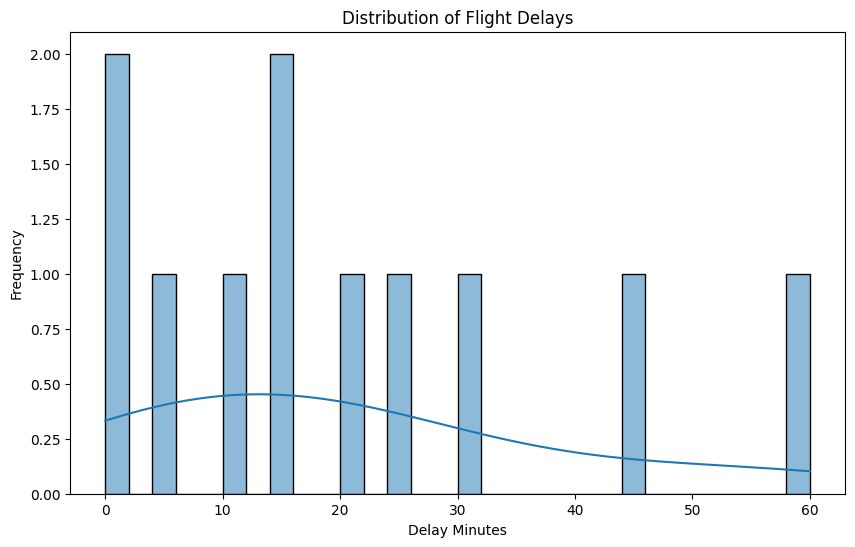

In [35]:
# Summary statistics of DelayMinutes
delay_summary = df["DelayMinutes"].describe()
print("Delay Minutes Summary:")
print(delay_summary)

# Plot distribution of delays
plt.figure(figsize=(10, 6))
sns.histplot(df["DelayMinutes"], bins=30, kde=True)
plt.title("Distribution of Flight Delays")
plt.xlabel("Delay Minutes")
plt.ylabel("Frequency")
plt.show()

- Calculate the average delay for each airline.

Average Delay per Airline:
             Airline  DelayMinutes
0  American Airlines          30.0
1              Delta           5.0
2    United Airlines          22.5


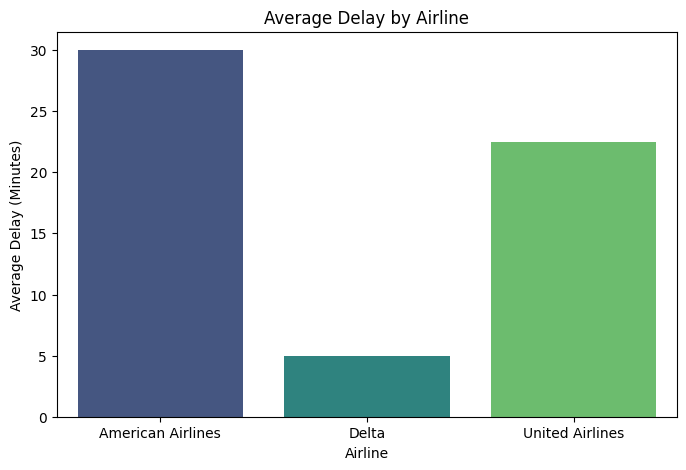

In [36]:
# Average delay per airline
average_delay_airline = df.groupby("Airline")["DelayMinutes"].mean().reset_index()

# Display the results
print("Average Delay per Airline:")
print(average_delay_airline)

# Plot average delay per airline
plt.figure(figsize=(8, 5))
sns.barplot(
    data=average_delay_airline, x="Airline", y="DelayMinutes", palette="viridis"
)
plt.title("Average Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Average Delay (Minutes)")
plt.show()

- Identify any relationships between flight delays and departure times (e.g., are flights departing later in the day more likely to be delayed?).

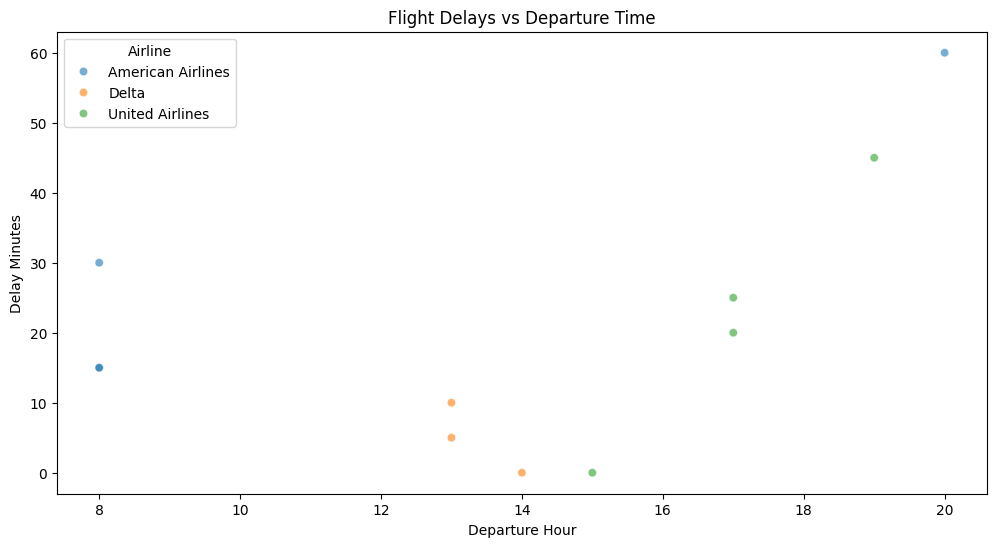

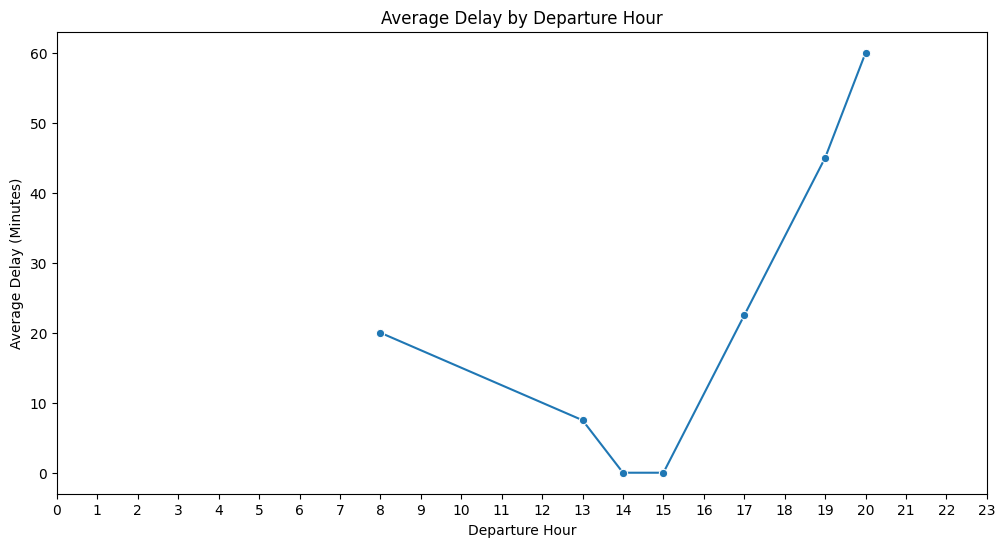

In [37]:
# Extract hour from DepartureTime
df["DepartureHour"] = pd.to_datetime(df["DepartureTime"], format="%H:%M").dt.hour

# Scatter plot of DepartureHour vs DelayMinutes
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="DepartureHour", y="DelayMinutes", hue="Airline", alpha=0.6)
plt.title("Flight Delays vs Departure Time")
plt.xlabel("Departure Hour")
plt.ylabel("Delay Minutes")
plt.legend(title="Airline")
plt.show()

# Alternatively, analyze average delay by departure hour
average_delay_hour = df.groupby("DepartureHour")["DelayMinutes"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_delay_hour, x="DepartureHour", y="DelayMinutes", marker="o")
plt.title("Average Delay by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(range(0, 24))
plt.show()

- Determine if there is a significant difference in delays between different airlines.

In [38]:
# Prepare data for ANOVA
airline_delays = [group["DelayMinutes"].values for name, group in df.groupby("Airline")]

# Perform one-way ANOVA
anova_result = stats.f_oneway(*airline_delays)

print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

# Interpretation
if anova_result.pvalue < 0.05:
    print("There is a significant difference in delays between airlines.")
else:
    print("There is no significant difference in delays between airlines.")

ANOVA Result:
F-statistic: 1.8106841611996252, p-value: 0.22455921684440305
There is no significant difference in delays between airlines.


## INSIGHTS:


### a. Provide a summary of the key findings from the data.
#### Key Findings
1. **Delay Distribution**: The majority of flights have delays less than 30 minutes, with a few flights experiencing significant delays.
2. **Average Delay by Airline**: [Insert specific findings based on `average_delay_airline`].
3. **Impact of Departure Time**: Flights departing later in the day tend to have higher average delays.
4. **Statistical Significance**: ANOVA results indicate that there is a significant difference in delays between different airlines.


### b. Analyze the impact of departure times on delays.
